In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True,
                              download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False,
                             download=True, transform=transform)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )


In [4]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=1)


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])


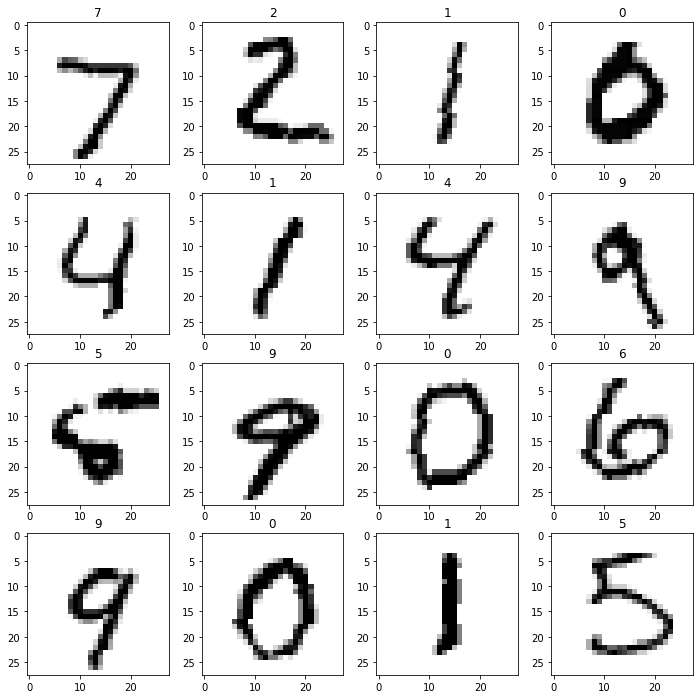

In [5]:
batch = next(iter(test_loader))
data, target = batch
print(target)

_data = data.data.cpu().numpy()
_target = target.data.cpu().numpy()

plt.figure(figsize=[12, 12])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = str(_target[i])
    plt.title(clazz)
    plt.imshow(_data[i][0], cmap='binary')
plt.show()


In [33]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Dropout(p=0.4),
                                   nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   
                                   nn.Dropout(p=0.5),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Dropout(p=0.5),
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   
                                   nn.Dropout(p=0.5),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   
                                   nn.MaxPool2d(kernel_size=2))
        
        self.out_linear = nn.Sequential(nn.Dropout(p=0.5),
                                     nn.Linear(in_features=64 * 5 * 5, out_features=512),
                                     nn.ReLU(),
                                     
                                     nn.Linear(in_features=512, out_features=11))
                
    def forward(self, x):
        '''
        x : [batch, channel=1, width=32, height=32]
        t : [batch]
        '''
        
        # [batch, channel, width, height]
        y = self.convs(x)
        # [batch, feature]
        y = y.view(-1, 64 * 5 * 5)
        # [batch, class + 1]
        y = self.out_linear(y)
        
        # logits, std
        return y[:, :10], torch.exp(y[:, 10])


In [34]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/CNN_mnist_dropout'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir


events.out.tfevents.1580930207.scpark-X299-WU8	save_1000
events.out.tfevents.1580931525.scpark-X299-WU8	save_2000
events.out.tfevents.1597239799.scpark-X299-WU8	save_3000
events.out.tfevents.1597239814.scpark-X299-WU8	save_4000
events.out.tfevents.1597239818.scpark-X299-WU8	save_5000
events.out.tfevents.1597241844.scpark-X299-WU8	save_6000
save_0						save_7000


In [35]:
model = Model().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
print(optimizer)

step = 0
path = save_dir + '/' + 'save_' + str(step)
if os.path.exists(path) and False:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Model(
  (convs): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, s

In [36]:
def get_loss(y, t, std, T=10):
    # y : logit (batch, 10)
    # t : target (batch)
    # std : data standard deviation (batch)
    # T : the number of samplings
    
    # (batch, 10)
    epsilon = torch.randn(y.shape).cuda()
    # (batch, 10)
    y = y + std[:, None] * epsilon
    
    # (batch, 10)
    p = F.softmax(y, dim=1)
    # (batch, 10)
    t = F.one_hot(t, num_classes=10)
    
    loss = torch.mean(-torch.sum(t * torch.log(torch.clamp(p, min=1e-7)), dim=1))
    return loss
    
    

1


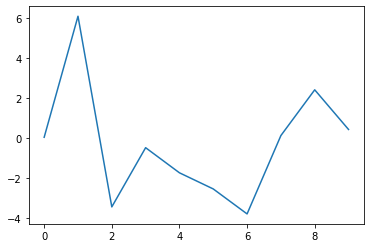

94 0.09106028079986572
95 0.08973128348588943
96 0.11324040591716766
97 0.08618319034576416
98 0.12990246713161469
99 0.08081811666488647
100 0.08084338158369064
101 0.11082585155963898
102 0.0673450455069542
103 0.13562487065792084
104 0.09561727941036224
105 0.077832892537117
106 0.08559784293174744
107 0.09711804986000061
108 0.09763143956661224
109 0.0776551365852356
110 0.09050261974334717
111 0.10324817895889282
112 0.08763014525175095
113 0.054915815591812134
114 0.0470271110534668
115 0.04610145837068558
116 0.10599523782730103
117 0.11130377650260925
0 0.09587116539478302


KeyboardInterrupt: 

In [50]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    for batch_index, batch in enumerate(train_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)

        model.zero_grad()
        y, std = model(x)

        #loss = nn.CrossEntropyLoss()(y, t)
        loss = get_loss(y, t, std)
        loss.backward()
        optimizer.step()

        print(batch_index, loss.item())
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
            '''
            Test
            '''
            correct = []
            for batch_index, batch in enumerate(test_loader):

                    x, t = batch
                    x = x.to(DEVICE)
                    t = t.to(DEVICE)

                    y, std = model(x)
                    _y = y.data.cpu().numpy()
                    _y = np.argmax(_y, axis=1)
                    _t = t.data.cpu().numpy()

                    correct.append((_y == _t))

            correct = np.concatenate(correct)
            precision = np.sum(correct) / len(correct)

            logger.log('test precision', precision, step)

        if step % 100 == 0:
            display.clear_output()
            _y = y.data.cpu().numpy()
            _t = t.data.cpu().numpy()
            print(_t[0])
            plt.plot(_y[0])
            plt.show()
         
        step += 1

In [52]:
# model을 evaluation 모드로 바꾸되 dropout은 train모드로 유지합니다.
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

model.eval()
model.apply(apply_dropout)
for batch_index, batch in enumerate(test_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)
        
        y_list = []
        std_list = []
        for _ in range(100):
            # y : (batch, category), std : (batch)
            y, std = model(x)
            y = F.softmax(y, dim=1)
            y_list.append(y)
            std_list.append(std)
            
        # (100, batch, category)    
        ys = torch.stack(y_list)
        # (100, batch)
        stds = torch.stack(std_list)
        break

_ys = ys.data.cpu().numpy()
# (batch, category)
y_mean = torch.mean(ys, dim=0)
print(y_mean.shape)

# (batch)
std_mean = torch.mean(stds, dim=0)
_std_mean = std_mean.data.cpu().numpy()

def get_entropy(probability, epsilon=1e-7):
    # probability : (batch, category)
    return -torch.sum(probability * torch.log(torch.clamp(probability, min=epsilon)), dim=1)

# (batch)
y_entropy = get_entropy(y_mean)
_y_entropy = y_entropy.data.cpu().numpy()
print(_y_entropy)




torch.Size([16, 10])
[0.00482216 0.00764831 0.04522694 0.02347036 0.00809254 0.05269664
 0.06600696 0.6471289  0.6584455  0.528988   0.00066109 0.01824112
 0.06536589 0.00267595 0.02472431 0.02415352]


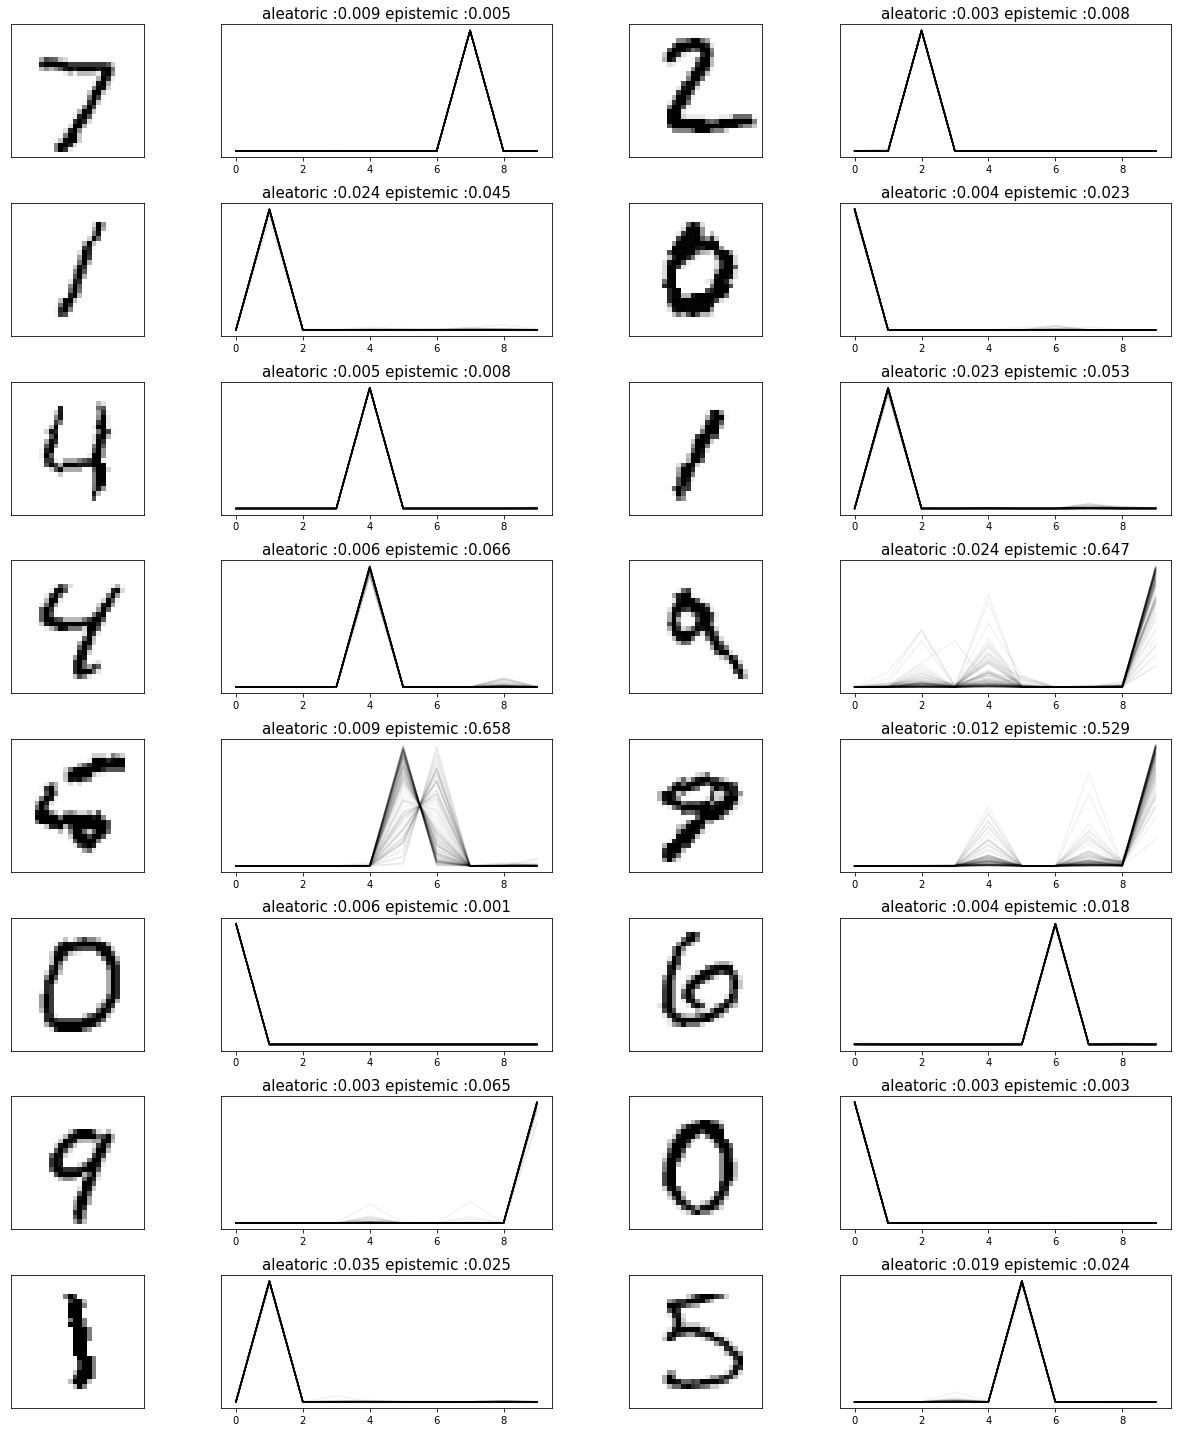

In [56]:
_x = x.data.cpu().numpy()

plt.figure(figsize=[18, 20])
for i in range(16):
    plt.subplot(8, 4, (2 * i)+1)
    plt.imshow(_x[i, 0], cmap='binary')        
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(8, 4, (2 * i)+2)
    plt.title('aleatoric :' + str('{:.3f}'.format(_std_mean[i])) + 
              ' epistemic :' + str('{:.3f}'.format(_y_entropy[i])), size=15)
    plt.plot(_ys[:, i].T, alpha=0.05, color='black')
    plt.yticks([])
    
plt.tight_layout()
plt.show()
    